In [5]:
import numpy as np
import matplotlib.pyplot as plt

def hopf(xy, step, params):
    x,y=xy
    alpha, mu, omega, u1, u2=params
    
    rsquare = (x-u1)**2+(y-u2)**2
    dx = alpha*(mu-rsquare)*(x-u1) - omega*(y-u2)
    dy = alpha*(mu-rsquare)*(y-u2) + omega*(x-u1)

    return [x+dx*step, y+dy*step]

def test_hopf(step, T):
    xy=[0.1, 0.1]
    alpha=100
    mu=1
    omega=2*np.pi
    u1=u2=0
    params=[alpha, mu, omega, u1, u2]

    ret = []

    steps = len(np.arange(0, T, step))
    for i in range(steps):
        xy=hopf(xy, step, params)
        ret.append(xy)
    return ret

[]

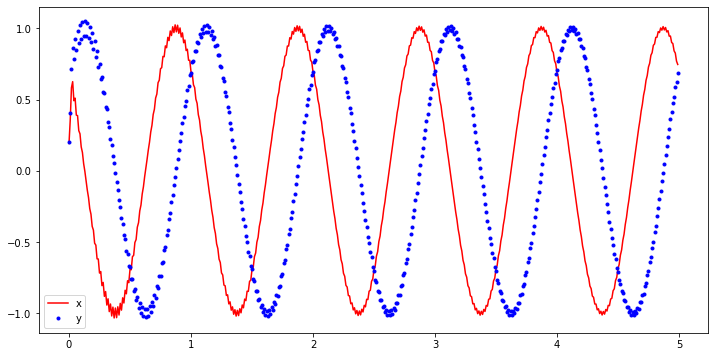

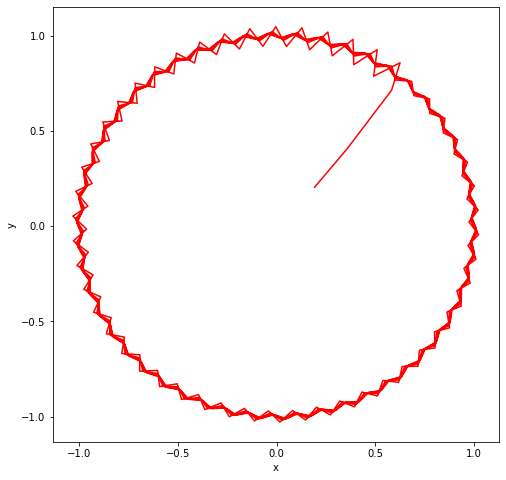

In [6]:
ret = np.array(test_hopf(step=0.01, T=5))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, 5, 0.01), ret[:,0], 'r', label='x')
ax.plot(np.arange(0, 5, 0.01), ret[:,1], 'b.', label='y')
ax.legend()

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ret[:,0], ret[:,1], 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.plot()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fomega_st(beta, omega_sw):
    return ((1-beta)/beta)*omega_sw

def fomega(a, beta, y, omega_sw):
    omega_st = fomega_st(beta, omega_sw)
    return omega_st/(np.exp(-a*y)+1) + omega_sw/(np.exp(a*y)+1)

In [ ]:
xy=[0.1, 0]
alpha=100
mu=1
a=50
beta=0.75 # 支撑相占3/4
omega_sw=4*np.pi
u1=u2=0

ret = []
step=0.01
T=5
steps = len(np.arange(0, T, step))
for i in range(steps):
    omega=fomega(a, beta, xy[1], omega_sw)
    params=[alpha, mu, omega, u1, u2]
    xy=hopf(xy, step, params)
    ret.append(xy)

ret = np.array(ret)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, 5, 0.01), ret[:,0], 'r', label='x')
#ax.plot(np.arange(0, 5, 0.01), ret[:,1], 'b.', label='y')
ax.legend()
plt.plot()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Quadfly():
    def __init__(self):
        self.l1 = 0.209
        self.l2 = 0.180
        self.angleh_s=-0.25*np.math.pi
        self.anglek_s=0.5*np.math.pi
        self.mu = 1
        self.alpha = 100
        self.a=100
        self.omega_sw=5*np.math.pi
        self.hk=1
        # pace:beta, (phi_LF, phi_RLF, phi_RH, phi_LH), v, h 
        self.walk_config={'beta':0.75, 'phi':[0,0.5,0.25,0.75], 'v':0.3, 'h':0.02}
        self.trot_config={'beta':0.5, 'phi':[0,0.5,0,0.5], 'v':1., 'h':0.02}
        self.pace_config={'beta':0.5, 'phi':[0,0.5,0.5,0], 'v':1.2,  'h':0.02}
        self.gallop_config={'beta':0.55, 'phi':[0,0.1,0.6,0.5], 'v':1.6, 'h':0.04}
        self.bound_config={'beta':0.5, 'phi':[0,0.,0.5,0.5], 'v':0.3,  'h':0.02}
        self.pronk_config={'beta':0.75, 'phi':[0,0,0,0], 'v':0.3, 'h':0.02}

        # sim
        self.step=0.001
        period=4
        self.steps = np.arange(0, period, self.step)
        # q = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
        q = np.array([0.1,0,0,0,0,0,0,0])
        self.Q = np.reshape(q, (8,1))

    def Ah(self, beta, v, T):
        return np.arcsin(0.5*beta*v*T / np.sqrt(self.l1**2+self.l2**2-2*self.l1*self.l2*np.cos(self.anglek_s-self.angleh_s)))
    
    def Ak(self, h):
        return np.arccos(np.cos(self.angleh_s+self.anglek_s)-h/self.l2)-(self.angleh_s+self.anglek_s)
    
    def fomega_st(self, beta):
        return ((1-beta)/beta)*self.omega_sw

    def fomega(self, beta, L):
        omega_st = self.fomega_st(beta)
        L1 = L[1,0]
        return omega_st/(np.exp(-self.a*L1)+1) + self.omega_sw/(np.exp(self.a*L1)+1)
    
    def angle_h(self, r):
        return r
    
    def angle_k(self, r,  Ah, Ak):
        if r <= 0:
            return -self.hk*Ak/Ah*r
        else:
            return 0.
    
    def angle(self, Q, config, ah, ak):
        ang = []
        for i in range(len(Q)):
            if i % 2 == 0:
                ang.append(self.angle_h(Q[i,0]))
            else:
                ang.append(self.angle_k(Q[i,0], ah, ak))
        return ang
    
    def Mi(self, L, omega):
        p = self.alpha*(self.mu-np.dot(L.T, L)[0,0])
        return np.array([[p, -omega],[omega, p]])

    def Ri(self, phi, i, j):
        theta = 2*np.math.pi*(phi[i]-phi[j])
        return np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    
    def R(self, phi):
        Rall=[]
        for i in range(4):
            Row=[]
            for j in range(4):
                Row.append(self.Ri(phi, i, j))
            
            Row = np.c_[Row[0], Row[1], Row[2], Row[3]]
            Rall.append(Row)
        return np.r_[Rall[0], Rall[1], Rall[2], Rall[3]]

    def hopf(self, Q, beta, phi):
        M = []
        for i in range(4):
            omega = self.fomega(beta, Q[i*2:(i+1)*2,:])
            Mitmp = np.dot(self.Mi(Q[i*2:(i+1)*2,:], omega), Q[i*2:(i+1)*2,:])
            M.append(Mitmp)
        #print('output', M[0])
        F = np.r_[M[0], M[1], M[2], M[3]]
        #print('R', np.dot(self.R(phi), Q))
        return F + np.dot(self.R(phi), Q)

    def run(self, config):
        omega_st = self.fomega_st(config['beta'])
        T = np.math.pi/self.omega_sw + np.math.pi/omega_st
        ah = self.Ah(config['beta'], config['v'], T)
        ak = self.Ak(config['h'])
        print('omega_st', omega_st, 'T', T, 'ah', ah, 'ak', ak)
    
        ang=[]
        for i in range(len(self.steps)):
            output = self.hopf(self.Q, config['beta'], config['phi'])
            self.Q = output*self.step + self.Q
            
            ang.append(self.angle(self.Q, config, ah, ak))

            #if i >= 100:
            #    break
        ret = np.array(ang)
        return ret

omega_st 15.707963267948966 T 0.4 ah 0.2818335794799774 ak 0.1468931275343246


[]

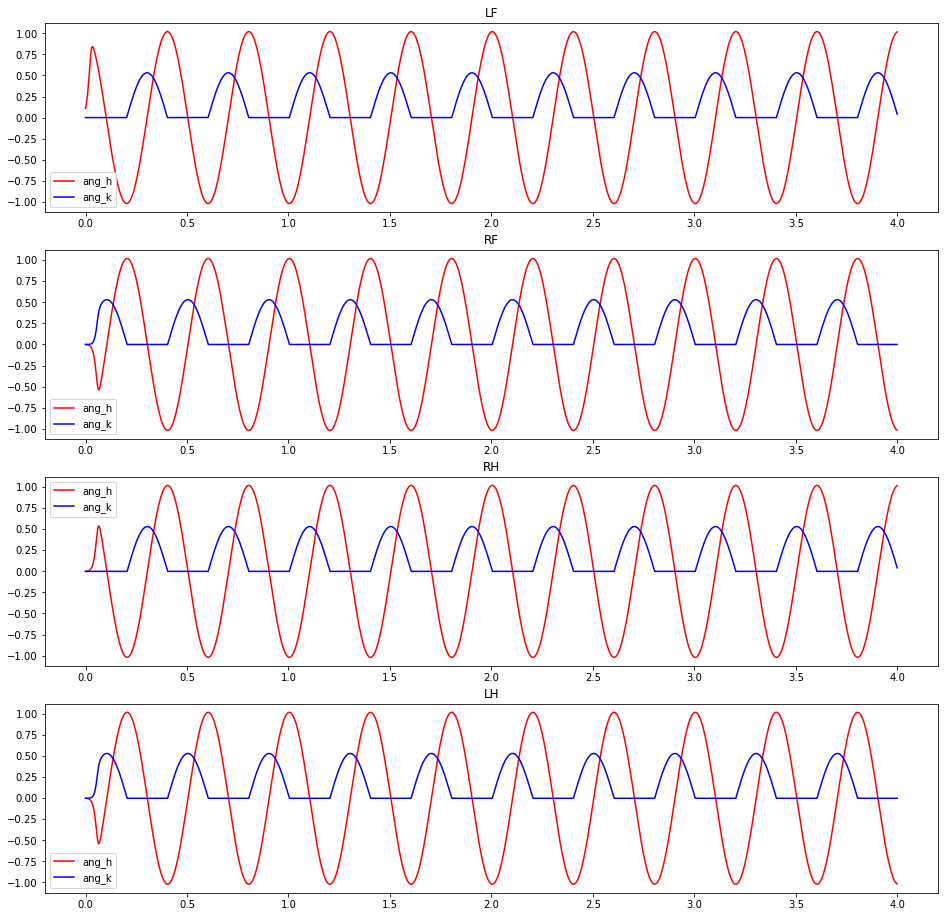

In [2]:
quad = Quadfly()
ret = quad.run(quad.trot_config)
#print(ret[0:20,0:2])

#fig, ax = plt.subplots(figsize=(16, 4))
step=0.001
period=4
steps = np.arange(0, period, step)
#ax.plot(steps, ret[:,0], 'r', label='ang_h')
#ax.plot(steps, ret[:,1], 'b', label='ang_k')
#ax.legend()
titles = ['LF', 'RF', 'RH', 'LH']
fig, ax = plt.subplots(4,1, figsize=(16, 16))
for i in range(4):
    ax[i].plot(steps, ret[:,i*2], 'r', label='ang_h')
    ax[i].plot(steps, ret[:,i*2+1], 'b', label='ang_k')
    ax[i].legend()
    ax[i].set_title(titles[i])
plt.plot()

In [ ]:
import numpy as np
a=np.array([[1,2],[3,4]])
b=np.array([[1,2],[3,4]])
c=np.array([[1,2],[3,4]])
d=np.array([2,2])
print(np.r_[a,b,c])
print(np.c_[a,b,c])
d=d.reshape((2,1))
print(a.shape, d.shape)
print(np.dot(a, d))

q = np.array([0,0,0,0,0,0,0,0])
Q =np.reshape(q, (8,1))
print(Q)
Q = np.reshape(Q, (8,))
print(Q)
L=np.array([[1],[2]])
print(np.dot(L.T, L))
print(np.exp(-100*L[0,0])+1)

In [5]:
print(np.math.degrees(0.16653500526931525))
print(np.math.degrees(1.9))

9.54175294312069
108.8619810748564


In [3]:
import numpy as np
print(np.math.radians(41.38627224469312))
print(np.math.radians(8.416356247193745))

a = np.array([1,1,1,1,1,-1,1,-1])
b = np.array([1,2,3,4,5,6,7,8])
print(a*b)

0.7223267157966392
0.14689312753432462
[ 1  2  3  4  5 -6  7 -8]


In [6]:
print(1/6.)

0.16666666666666666
